In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from torchvision import get_image_backend

import torch
import torchvision
import torchsummary
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from google.colab import files

from tqdm.notebook import tqdm
import warnings
import os

warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
data  = pd.read_csv('/content/drive/My Drive/AdienceBenchmarkGenderAndAgeClassification/fold_0_data.txt', sep='\t')
data1 = pd.read_csv('/content/drive/My Drive/AdienceBenchmarkGenderAndAgeClassification/fold_1_data.txt', sep='\t')
data2 = pd.read_csv('/content/drive/My Drive/AdienceBenchmarkGenderAndAgeClassification/fold_2_data.txt', sep='\t')
data3 = pd.read_csv('/content/drive/My Drive/AdienceBenchmarkGenderAndAgeClassification/fold_3_data.txt', sep='\t')
data4 = pd.read_csv('/content/drive/My Drive/AdienceBenchmarkGenderAndAgeClassification/fold_4_data.txt', sep='\t')

In [ ]:
data.shape
total_shape = (data.shape[0]+data1.shape[0]+data2.shape[0]+data3.shape[0]+data4.shape[0], data.shape[1])
print(total_shape)

(19370, 12)


In [ ]:
data.columns

Index(['user_id', 'original_image', 'face_id', 'age', 'gender', 'x', 'y', 'dx',
       'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score'],
      dtype='object')

In [ ]:
data.dtypes

user_id               object
original_image        object
face_id                int64
age                   object
gender                object
x                      int64
y                      int64
dx                     int64
dy                     int64
tilt_ang               int64
fiducial_yaw_angle     int64
fiducial_score         int64
dtype: object

In [ ]:
data.describe()

,face_id,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
count,4484.000000,4484.000000,4484.000000,4484.000000,4484.000000,4484.000000,4484.000000,4484.000000
mean,181.365299,888.913024,664.133586,730.582516,722.762935,-8.220785,3.408787,74.749554
std,146.967930,641.385657,460.556195,505.217378,478.369254,84.321376,15.410016,39.049674
min,1.000000,0.000000,0.000000,100.000000,100.000000,-200.000000,-45.000000,5.000000
25%,18.000000,364.000000,298.000000,388.000000,389.000000,-85.000000,0.000000,44.000000
50%,186.000000,793.000000,618.000000,617.000000,613.000000,-5.000000,0.000000,72.000000
75%,319.250000,1316.000000,976.500000,854.000000,854.250000,10.000000,0.000000,101.000000
max,480.000000,4983.000000,2752.000000,3264.000000,3225.000000,270.000000,45.000000,206.000000


In [ ]:
data.head(10)

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34
5,30601258@N03,11562582716_dbc2eb8002_o.jpg,1,"(25, 32)",f,0,422,1332,1498,-100,15,54
6,30601258@N03,10424595844_1009c687e4_o.jpg,4,"(38, 43)",f,1912,905,1224,1224,155,0,64
7,30601258@N03,9506931745_796300ca4a_o.jpg,5,"(25, 32)",f,1069,581,1575,1575,0,30,131
8,30601258@N03,10190308156_5c748ab2da_o.jpg,5,"(25, 32)",f,474,1893,485,484,-115,30,55
9,30601258@N03,10190308156_5c748ab2da_o.jpg,2,"(25, 32)",m,1013,1039,453,452,-75,0,59


In [ ]:
data.fillna("0", inplace=True)
data1.fillna("0", inplace=True)
data2.fillna("0", inplace=True)
data3.fillna("0", inplace=True)
data4.fillna("0", inplace=True)

In [ ]:
transform = transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
])

In [ ]:
all_pics_names = []
pics_path = []
for subdir, dirs, files1 in os.walk('/content/drive/My Drive/AdienceBenchmarkGenderAndAgeClassification/faces'):
    for file in files1:
      if file.endswith(".jpg"):
        if file[26] == '.':
          f = file[27:]
        elif file[27] == '.':
          f = file[28:]
        elif file[28] == '.':
          f = file[29:]
        elif file[29] == '.':
          f = file[30:]
        all_pics_names.append(f)
        pics_path.append(os.path.join(subdir, file))

In [ ]:
def findGender(pic):
  if data.index[data['original_image'] == pic].tolist():
    index = data.index[data['original_image'] == pic].tolist()[0]
    fold_file = data
  elif data1.index[data1['original_image'] == pic].tolist():
    index = data1.index[data1['original_image'] == pic].tolist()[0]
    fold_file = data1
  elif data2.index[data2['original_image'] == pic].tolist():
    index = data2.index[data2['original_image'] == pic].tolist()[0]
    fold_file = data2
  elif data3.index[data3['original_image'] == pic].tolist():
    index = data3.index[data3['original_image'] == pic].tolist()[0]
    fold_file = data3
  elif data4.index[data4['original_image'] == pic].tolist():
    index = data4.index[data4['original_image'] == pic].tolist()[0]
    fold_file = data4
  gender = fold_file['gender'][index]
  if gender == 'm':
    return "male"
  return "female"

In [ ]:
class MyDataset(Dataset):
  def __init__(self, image_path, transform=None):
    super(MyDataset, self).__init__()
    self.transform = transform
    self.classes, self.class_to_idx = self._find_classes(image_path)
    self.samples = self.make_dataset(image_path, self.class_to_idx)
    self.targets = [s[1] for s in self.samples]

  def _find_classes(self, dir):
    classes = ['male', 'female']
    class_to_idx = {'male' : 0,
                    'female' : 1}
    return classes, class_to_idx

  def _get_target(self, file_path):
    if file_path[26] == '.':
      f = file_path[27:]
    if file_path[27] == '.':
      f = file_path[28:]
    elif file_path[28] == '.':
      f = file_path[29:]
    elif file_path[29] == '.':
      f = file_path[30:]
    return findGender(f)
  
  def make_dataset(self, dir, class_to_idx):
    images = []
    for subdir, dirs, files in os.walk('/content/drive/My Drive/AdienceBenchmarkGenderAndAgeClassification/faces'):
      for file in files:
        if file.endswith(".jpg"):
          target = self._get_target(file)
          item = (os.path.join(subdir, file), class_to_idx[target])
          images.append(item)
    return images

  def __getitem__(self, index):
    path, target = self.samples[index]
    sample = self.default_loader(path)
    sample = self.transform(sample)
    return sample, target

  def get_class_dict(self):
    return self.class_to_idx

  def default_loader(self, path):
    if get_image_backend() == 'accimage':
      return self.accimage_loader(path)
    else:
      return self.pil_loader(path)

  def __len__(self):
    return len(self.samples)

  def accimage_loader(self, path):
    import accimage
    try:
      return accimage.Image(path)
    except IOError:
      return self.pil_loader(path)

  def pil_loader(self, path):
    with open(path, 'rb') as f:
      img = Image.open(f)
      return img.convert('RGB')

In [ ]:
my_dataset = MyDataset('/content/drive/My Drive/AdienceBenchmarkGenderAndAgeClassification/faces', transform)

In [ ]:
print(my_dataset.classes)
print(my_dataset.class_to_idx)

['male', 'female']
{'male': 0, 'female': 1}


In [ ]:
classes = my_dataset.classes
print(len(classes))
print(classes)

2
['male', 'female']


In [ ]:
train_data, test_data = torch.utils.data.random_split(my_dataset, [15496, 3874])

In [ ]:
print('Train dataset size:', len(train_data))
print('Test dataset size:', len(test_data))

Train dataset size: 15496
Test dataset size: 3874


In [ ]:
train_loader = DataLoader(train_data,
                          batch_size=16,
                          shuffle=True)

test_loader = DataLoader(test_data,
                          batch_size=16,
                          shuffle=False)

In [ ]:
def show_imgs(imgs, title):
  imgs = imgs.cpu()
  mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
  std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

  imgs = imgs * std + mean
  img_grid = torchvision.utils.make_grid(imgs, nrow=4)
  img_np = img_grid.numpy()
  img_np = np.transpose(img_np, (1,2,0))

  plt.figure(figsize=(8,4))
  plt.imshow(img_np)
  plt.title(title)
  plt.show()

Training Examples: 


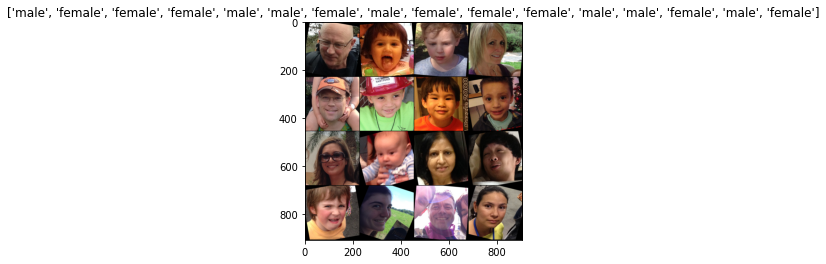

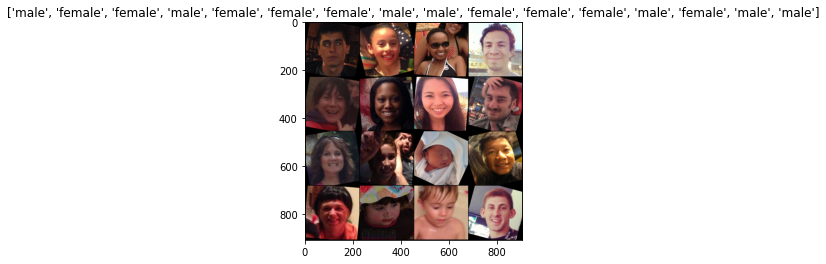

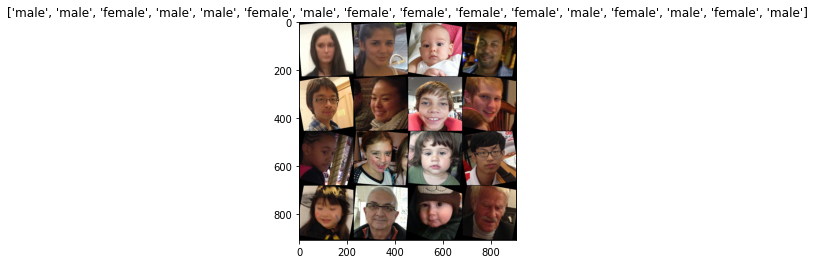

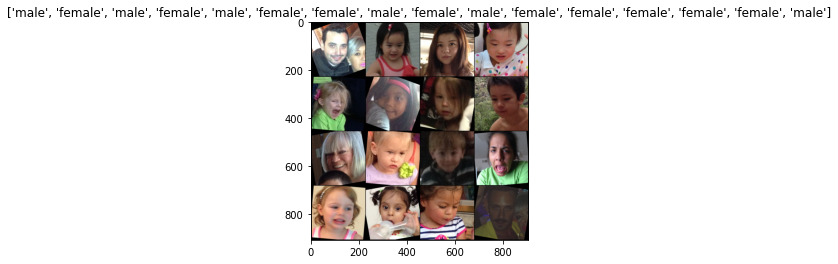

In [ ]:
print('Training Examples: ')

for i, batch in enumerate(train_loader):
  if i == 4:
    break
  images, labels = batch
  show_imgs(images, str([classes[i] for i in labels]))

Test Examples: 


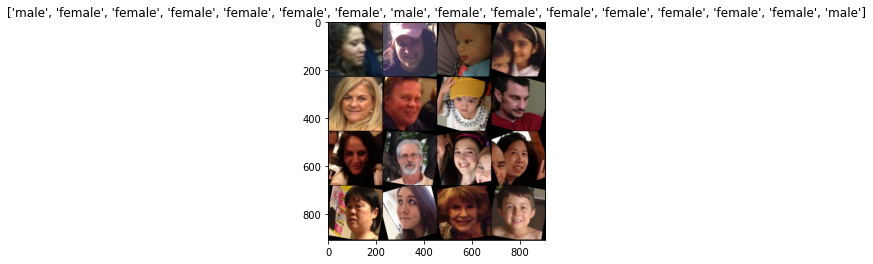

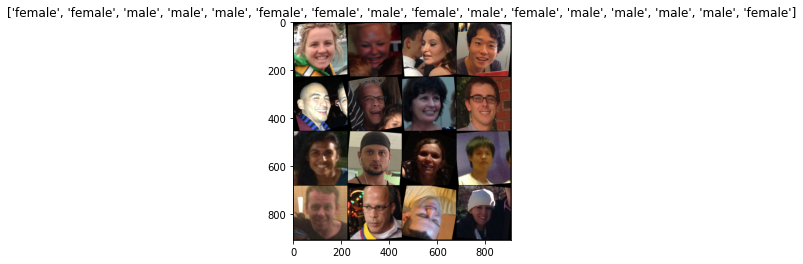

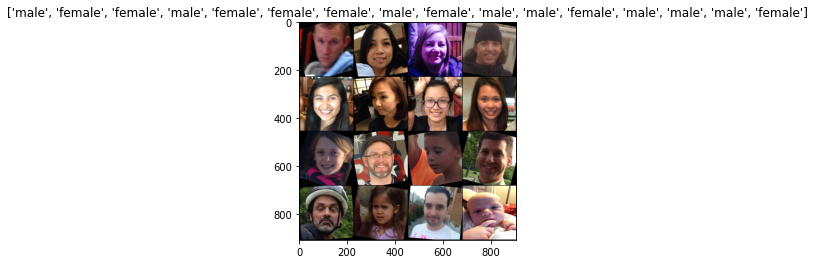

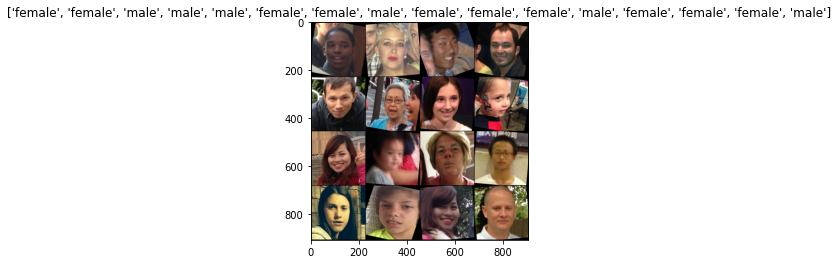

In [ ]:
print('Test Examples: ')

for i, batch in enumerate(test_loader):
  if i == 4:
    break
  images, labels = batch
  show_imgs(images, str([classes[i] for i in labels]))

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)
resnet

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
torchsummary.summary(resnet.to(device), input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
for param in resnet.parameters():
  param.requires_grad = False

In [ ]:
resnet.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, len(classes))

resnet.fc

Linear(in_features=512, out_features=2, bias=True)

In [ ]:
for param in resnet.parameters():
  if param.requires_grad == True:
    print(param.size())

torch.Size([2, 512])
torch.Size([2])


In [ ]:
def evaluate(model, dataloader):
  total, correct = 0, 0
  model.eval()
  for batch in dataloader:
    images, labels = batch
    images, labels = images.to(device), labels.to(device)

    outs = model(images)
    outs_labels = torch.argmax(outs, axis=1)

    total += labels.size(0)
    correct += (labels == outs_labels).sum().item()
    
  return 100 * correct/total

In [ ]:
import copy


def train(model, modelname, loss_fn, optimizer, train_loader, test_loader, epochs):
  hist = {'epoch_loss': [],
          'train_acc': [],
          'test_acc': []}
  min_loss = 10000
  for epoch in tqdm(range(1, epochs+1), total=epochs, desc='Training last layer'):
    losses = []
    for batch in train_loader:
      images, labels = batch
      images, labels = images.to(device), labels.to(device)

      model.train()

      outs = model(images)
      loss = loss_fn(outs, labels)

      losses.append(loss.item())

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()

      del images, labels, outs
      torch.cuda.empty_cache()

    curr_epoch_loss = np.array(losses).mean()
    hist['epoch_loss'].append(curr_epoch_loss)
    hist['train_acc'].append(evaluate(model, train_loader))
    hist['test_acc'].append(evaluate(model, test_loader))

    if curr_epoch_loss < min_loss:
      min_loss = curr_epoch_loss
      best_model = copy.deepcopy(model.state_dict())

  fig, ax = plt.subplots(ncols=2, figsize=(12,6))
  ax[0].plot(range(1, epochs+1), hist['epoch_loss'], label='Loss')
  ax[0].plot(range(1, epochs+1), np.ones(epochs)*min_loss, 'r--', alpha=0.6,
             label='Min Loss={}'.format(min_loss))
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Epochs vs. Loss')
  ax[0].grid()
  ax[0].legend()

  ax[1].plot(range(1, epochs+1), hist['train_acc'], 'b--', alpha=0.8,
             label='Train Accuracy')
  ax[1].plot(range(1, epochs+1), hist['test_acc'], 'r--', alpha=0.8,
             label='Test Accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy Score')
  ax[1].set_title('Epochs vs. Accuracy Score')
  ax[1].grid()
  ax[1].legend()

  plt.plot()

  torch.save(best_model, '{0}_{1:.4f}.pth'.format(modelname, min_loss))
  print("Best loss value: {}".format(min_loss))

  files.download('{0}_{1:.4f}.pth'.format(modelname, min_loss))

  return best_model

In [ ]:
resnet = resnet.to(device)

opt = torch.optim.Adam(resnet.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

resnet_wts = train(resnet, 'resnet',
                   loss_fn, opt,
                   train_loader,
                   test_loader, 10)

In [ ]:
resnet.load_state_dict(torch.load('/content/drive/My Drive/Classroom/ML Internship IndianServers Batch 14/resnet_0.5625(FP_gender)(1).pth'))

<All keys matched successfully>

In [ ]:
resnet = resnet.cpu()
test_batch1 = next(iter(test_loader))
pred_batch1 = resnet(test_batch1[0])
pred_labels1 = torch.argmax(pred_batch1, axis=1)
print("Predictions    :  ", end=" ")
for i in range(len(pred_labels1)):
  print(classes[pred_labels1[i].item()], end=", ")
print()
print("Actual Labels  :  ", end=" ")
for i in range(len(test_batch1[1])):
  print(classes[test_batch1[1][i].item()], end=", ")
print()
n = 0
for i in range(len(pred_batch1)):
  if (pred_labels1[i].item() == test_batch1[1][i].item()):
    n += 1
print("Accuracy : " + str(100*(n/len(pred_batch1))))

Predictions    :   male, male, female, male, male, male, female, female, female, female, male, female, female, male, male, female, 
Actual Labels  :   male, male, female, male, male, female, female, female, female, female, male, female, female, male, female, male, 
Accuracy : 81.25


In [ ]:
def findAge(pic):
  if data.index[data['original_image'] == pic].tolist():
    index = data.index[data['original_image'] == pic].tolist()[0]
    fold_file = data
  elif data1.index[data1['original_image'] == pic].tolist():
    index = data1.index[data1['original_image'] == pic].tolist()[0]
    fold_file = data1
  elif data2.index[data2['original_image'] == pic].tolist():
    index = data2.index[data2['original_image'] == pic].tolist()[0]
    fold_file = data2
  elif data3.index[data3['original_image'] == pic].tolist():
    index = data3.index[data3['original_image'] == pic].tolist()[0]
    fold_file = data3
  elif data4.index[data4['original_image'] == pic].tolist():
    index = data4.index[data4['original_image'] == pic].tolist()[0]
    fold_file = data4
  age = fold_file['age'][index]
  return age

In [ ]:
class MyDatasetAge(Dataset):
  def __init__(self, image_path, transform=None):
    super(MyDatasetAge, self).__init__()
    self.transform = transform
    self.classes, self.class_to_idx = self._find_classes(image_path)
    self.samples = self.make_dataset(image_path, self.class_to_idx)
    self.targets = [s[1] for s in self.samples]

  def _find_classes(self, dir):
    classes = []
    for i in range(len(data['age'])):
      if (data['age'][i] not in classes):
        classes.append(data['age'][i])
    for i in range(len(data1['age'])):
      if (data1['age'][i] not in classes):
        classes.append(data1['age'][i])
    for i in range(len(data2['age'])):
      if (data2['age'][i] not in classes):
        classes.append(data2['age'][i])
    for i in range(len(data3['age'])):
      if (data3['age'][i] not in classes):
        classes.append(data3['age'][i])
    for i in range(len(data4['age'])):
      if (data4['age'][i] not in classes):
        classes.append(data4['age'][i])
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

  def _get_target(self, file_path):
    if file_path[26] == '.':
      f = file_path[27:]
    if file_path[27] == '.':
      f = file_path[28:]
    elif file_path[28] == '.':
      f = file_path[29:]
    elif file_path[29] == '.':
      f = file_path[30:]
    return findAge(f)
  
  def make_dataset(self, dir, class_to_idx):
    images = []
    for subdir, dirs, files in os.walk('/content/drive/My Drive/AdienceBenchmarkGenderAndAgeClassification/faces'):
      for file in files:
        if file.endswith(".jpg"):
          target = self._get_target(file)
          item = (os.path.join(subdir, file), class_to_idx[target])
          images.append(item)
    return images

  def __getitem__(self, index):
    path, target = self.samples[index]
    sample = self.default_loader(path)
    sample = self.transform(sample)
    return sample, target

  def get_class_dict(self):
    return self.class_to_idx

  def default_loader(self, path):
    if get_image_backend() == 'accimage':
      return self.accimage_loader(path)
    else:
      return self.pil_loader(path)

  def __len__(self):
    return len(self.samples)

  def accimage_loader(self, path):
    import accimage
    try:
      return accimage.Image(path)
    except IOError:
      return self.pil_loader(path)

  def pil_loader(self, path):
    with open(path, 'rb') as f:
      img = Image.open(f)
      return img.convert('RGB')

In [ ]:
my_dataset_age = MyDatasetAge('/content/drive/My Drive/AdienceBenchmarkGenderAndAgeClassification/faces', transform)

In [ ]:
print(my_dataset_age.classes)
print(my_dataset_age.class_to_idx)

['(25, 32)', '(38, 43)', '(4, 6)', '(60, 100)', '(15, 20)', '(48, 53)', '(8, 12)', '(0, 2)', 'None', '(38, 48)', '35', '3', '55', '58', '22', '13', '45', '36', '23', '(38, 42)', '(8, 23)', '(27, 32)', '57', '56', '2', '29', '34', '42', '46', '32']
{'(25, 32)': 0, '(38, 43)': 1, '(4, 6)': 2, '(60, 100)': 3, '(15, 20)': 4, '(48, 53)': 5, '(8, 12)': 6, '(0, 2)': 7, 'None': 8, '(38, 48)': 9, '35': 10, '3': 11, '55': 12, '58': 13, '22': 14, '13': 15, '45': 16, '36': 17, '23': 18, '(38, 42)': 19, '(8, 23)': 20, '(27, 32)': 21, '57': 22, '56': 23, '2': 24, '29': 25, '34': 26, '42': 27, '46': 28, '32': 29}


In [ ]:
classes1 = my_dataset_age.classes
print(len(classes1))
print(classes1)

30
['(25, 32)', '(38, 43)', '(4, 6)', '(60, 100)', '(15, 20)', '(48, 53)', '(8, 12)', '(0, 2)', 'None', '(38, 48)', '35', '3', '55', '58', '22', '13', '45', '36', '23', '(38, 42)', '(8, 23)', '(27, 32)', '57', '56', '2', '29', '34', '42', '46', '32']


In [ ]:
train_data1, test_data1 = torch.utils.data.random_split(my_dataset_age, [15496, 3874])

In [ ]:
print('Train dataset size:', len(train_data1))
print('Test dataset size:', len(test_data1))

Train dataset size: 15496
Test dataset size: 3874


In [ ]:
train_loader1 = DataLoader(train_data1,
                          batch_size=16,
                          shuffle=True)

test_loader1 = DataLoader(test_data1,
                          batch_size=16,
                          shuffle=False)

In [ ]:
resnet_age = torchvision.models.resnet18(pretrained=True)
resnet_age

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
torchsummary.summary(resnet_age.to(device), input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
for param in resnet_age.parameters():
  param.requires_grad = False

In [ ]:
resnet_age.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
in_features = resnet_age.fc.in_features
resnet_age.fc = nn.Linear(in_features, len(classes1))

resnet_age.fc

Linear(in_features=512, out_features=30, bias=True)

In [ ]:
for param in resnet_age.parameters():
  if param.requires_grad == True:
    print(param.size())

torch.Size([30, 512])
torch.Size([30])


In [ ]:
resnet_age = resnet_age.to(device)

opt = torch.optim.Adam(resnet_age.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

resnet_age_wts = train(resnet_age, 'resnet_age',
                      loss_fn, opt,
                      train_loader1,
                      test_loader1, 10)

In [ ]:
resnet_age.load_state_dict(torch.load('/content/drive/My Drive/Classroom/ML Internship IndianServers Batch 14/resnet_age_1.7669(FP_age).pth'))

<All keys matched successfully>

In [ ]:
resnet_age = resnet_age.cpu()
test_batch2 = next(iter(test_loader1))
pred_batch2 = resnet_age(test_batch2[0])
pred_labels2 = torch.argmax(pred_batch2, axis=1)
print("Predictions    :  ", end=" ")
for i in range(len(pred_labels2)):
  print(classes1[pred_labels2[i].item()], end=", ")
print()
print("Actual Labels  :  ", end=" ")
for i in range(len(test_batch2[1])):
  print(classes1[test_batch2[1][i].item()], end=", ")
print()
n = 0
for i in range(len(pred_batch2)):
  if (pred_labels2[i].item() == test_batch2[1][i].item()):
    n += 1
print("Accuracy : " + str(100*(n/len(pred_batch2))))

Predictions    :   (25, 32), None, (25, 32), (25, 32), (8, 12), (0, 2), (38, 43), (0, 2), (25, 32), (25, 32), (25, 32), (25, 32), (25, 32), (8, 12), (25, 32), (25, 32), 
Actual Labels  :   (25, 32), None, (48, 53), (25, 32), (8, 12), (0, 2), (38, 43), (0, 2), (25, 32), (38, 43), (25, 32), (38, 43), (25, 32), (8, 12), (15, 20), (15, 20), 
Accuracy : 68.75


In [ ]:
test_image = '/content/drive/My Drive/Classroom/ML Internship IndianServers Batch 14/Datasets/test_image_9.jpg'

In [ ]:
def demo_gender(path):
  img = Image.open(path)
  img = transform(img)
  img = img.unsqueeze(0)
  model = resnet.cpu()
  pred = model(img)
  pred = torch.argmax(pred, axis=1)
  print(classes[pred.item()])

In [ ]:
def demo_age(path):
  img = Image.open(path)
  img = transform(img)
  img = img.unsqueeze(0)
  model = resnet_age.cpu()
  pred = model(img)
  pred = torch.argmax(pred, axis=1)
  print(classes1[pred.item()])

In [ ]:
def demo_gender_age(pic):
  img = Image.open(pic)
  plt.imshow(img)
  demo_gender(pic)
  demo_age(pic)

female
(25, 32)


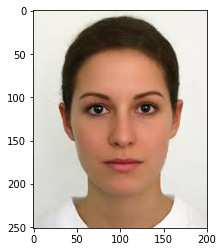

In [ ]:
demo_gender_age(test_image)